<a href="https://colab.research.google.com/github/Abhinavpanjiyar1/Pytorch/blob/main/pytorch_CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import torch
 import torch.nn as nn
 import torchvision
 import torchvision.transforms as transforms
 import numpy as np
 import matplotlib.pyplot as plt
 from datetime import datetime


In [2]:
train_dataset = torchvision.datasets.FashionMNIST(root = '.',
                                                 train = True,
                                                 transform =transforms.ToTensor(),
                                                 download = True)


100%|██████████| 26421880/26421880 [00:01<00:00, 13389202.36it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206653.04it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1548246.24it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5933574.33it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(root = '.',
                                                train = False,
                                                transform = transforms.ToTensor(),
                                                download = True)

In [7]:
# number of classes
K= len(set(train_dataset.targets.numpy()))
print("Number of classes:", K)


Number of classes: 10


In [8]:
#define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__() # No changes are required here, the syntax is correct
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 2),
        nn.ReLU(),
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2),
        nn.ReLU()
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

# Check if 'CNN' has been overwritten
print(type(CNN)) # Should output <class 'type'>

# If it's not a type, reset it
# del CNN
# Now try running 'model = CNN(K)' again


<class 'type'>


In [9]:
model = CNN(K)

In [10]:
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters())


In [12]:
#data loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle =True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

In [13]:
#TRAINING
num_epochs = 10
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses= np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradient
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimizer
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    #get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs =model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    # save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    dt = datetime.now() - t0
    print(f"epochs: {it+1}/ {epochs}, Train loss:{train_loss:.4f}, test loss: {test_loss:.4f}, Duration:{dt}")

  return train_losses, test_losses


In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, num_epochs)

epochs: 1/ 10, Train loss:0.6500, test loss: 0.4629, Duration:0:00:10.688210
epochs: 2/ 10, Train loss:0.4250, test loss: 0.4000, Duration:0:00:12.147123
epochs: 3/ 10, Train loss:0.3703, test loss: 0.3617, Duration:0:00:08.746342
epochs: 4/ 10, Train loss:0.3325, test loss: 0.3380, Duration:0:00:09.472743
epochs: 5/ 10, Train loss:0.3057, test loss: 0.3324, Duration:0:00:09.233872
epochs: 6/ 10, Train loss:0.2827, test loss: 0.3086, Duration:0:00:08.904657
epochs: 7/ 10, Train loss:0.2668, test loss: 0.2928, Duration:0:00:09.071063
epochs: 8/ 10, Train loss:0.2495, test loss: 0.3011, Duration:0:00:09.614673
epochs: 9/ 10, Train loss:0.2366, test loss: 0.3010, Duration:0:00:09.448232
epochs: 10/ 10, Train loss:0.2201, test loss: 0.2938, Duration:0:00:09.178538


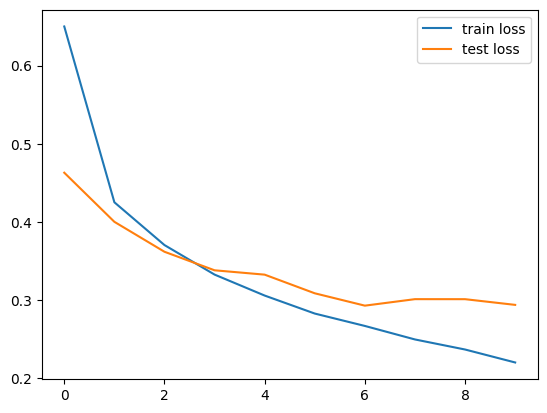

In [15]:
# plot the train loss and test loss per iteration
plt.plot(train_losses, label ='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()


In [22]:
#accuracy
model.eval()
n_correct = 0
n_total  =0
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  # get prediction
  _,predictions = torch.max(outputs, 1)

  # update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

model.eval()
n_correct = 0
n_total  =0
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  # get prediction
  _,predictions = torch.max(outputs, 1)

  # update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"train acc:{train_acc:.4f}, test acc:{test_acc:.4f}")



train acc:0.9335, test acc:0.8984
